In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras 
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
import model_symmetries as vsf
%matplotlib inline

Using TensorFlow backend.


In [2]:
import numpy as np
import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from keras.models import Model
from keras.utils import to_categorical

In [3]:
from skmultiflow.drift_detection.adwin import ADWIN

In [4]:
import streaming_sim_test as sst

In [5]:
from importlib import reload

In [6]:
from sklearn.neighbors import NearestNeighbors

In [7]:
import colorama
from colorama import Fore, Style

In [8]:
def evaluate(clf, X, y):
    y_preds = clf.predict(X)
    y_preds = np.argmax(y_preds, axis=1)
    y = np.argmax(y, axis=1)
    print('Accuracy:', accuracy_score(y_preds, y))
    print('Confusion matrix:', confusion_matrix(y_preds, y))

In [9]:
def make_data_stream(signal, agg='mean', window = 100, start=0):
    if agg == 'window':
        data_stream = []
        for i in range(len(signal)):
            data_stream.append(signal[i:i + window].mean())
        data_stream = np.asarray(data_stream)
        df = pd.Series(data_stream, name='stream').to_frame().reset_index()

    elif agg == 'mean':
        data_stream = np.zeros(len(signal) - start)
        mu = Mean()
        var = Var()
        for i in range(len(data_stream)):
            mu.update(signal[i + start])
            data_stream[i] = mu.get()
        df = pd.DataFrame()
        df['stream_raw'] = signal[start:]
        df['stream'] = data_stream
        df.reset_index(inplace=True)

    elif agg == 'raw':
        data_stream = signal
        df = pd.Series(data_stream, name='stream').to_frame().reset_index()
    return df

# Cifar

In [10]:
def prepare_data_cifar(permute=False, perm_features=50, contam_cifar100=False):
    
    cifar = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar
    print('x_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
        
    if not permute:
        idxs_train_0_5 = np.where((y_train == 5) | (y_train == 4) | (y_train == 3) | 
                            (y_train == 2) | (y_train == 1) | (y_train == 0))
        idxs_test_0_5 = np.where((y_test == 5) | (y_test == 4) | (y_test == 3) | 
                            (y_test == 2) | (y_test == 1) | (y_test == 0))

        idxs_train_6_9 = np.where((y_train == 6) | (y_train == 7) | (y_train == 8) | 
                            (y_train == 9))
        idxs_test_6_9 = np.where((y_test == 6) | (y_test == 7) | (y_test == 8) | 
                            (y_test == 9))

        print(idxs_train_0_5[0].shape)
        print(idxs_test_0_5[0].shape)

        X_train_0_5 = X_train[idxs_train_0_5[0]]
        y_train_0_5 = y_train[idxs_train_0_5[0]]

        X_test_0_5 = X_test[idxs_test_0_5[0]]
        y_test_0_5 = y_test[idxs_test_0_5[0]]
    
        X_6_9 = X_test[idxs_test_6_9[0]]
        y_6_9 = y_test[idxs_test_6_9[0]]

        y_train_0_5 = tf.keras.utils.to_categorical(y_train_0_5)
        y_test_0_5 = tf.keras.utils.to_categorical(y_test_0_5)
        y_6_9 = tf.keras.utils.to_categorical(y_6_9)
    
        y_6_9 = np.delete(y_6_9, np.where(~y_6_9.any(axis=0)), axis=1)
        print(X_train_0_5.shape, y_train_0_5.shape)
        print(X_test_0_5.shape, y_test_0_5.shape)
        print(X_6_9.shape, y_6_9.shape)
        return None, None, X_train_0_5, y_train_0_5, X_test_0_5, y_test_0_5, X_6_9, y_6_9 
    else:
        mapp = {(32 * i) + j: [i, j]  for i in range(32) for j in range(32)}
        perm_1 = np.random.permutation(range(32 * 32))[:perm_features]
        perm_2 = np.random.permutation(range(32 * 32))[:perm_features]
        X_cd = X_test.copy()
        for t in zip(perm_1, perm_2):
            X_cd[:, mapp[t[0]][0], mapp[t[0]][1], :] = X_cd[:, mapp[t[1]][0], mapp[t[1]][1], :]
        y_cd = y_test
        
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        y_cd = tf.keras.utils.to_categorical(y_cd)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        print(X_cd.shape, y_cd.shape)
        return None, None, X_train, y_train, X_test, y_test, X_cd, y_cd

In [11]:
def model_cifar():
    x_in = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3),  activation='relu')(x_in)
    x = tf.keras.layers.Conv2D(32, (3, 3),  activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x_out = tf.keras.layers.Dense(10, activation='softmax')(x)
    
    cnn = tf.keras.models.Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
    
    return cnn

### Prepare data

In [12]:
_, _, X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_cifar(permute=True, perm_features=50)

x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)
(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)
(10000, 32, 32, 3) (10000, 10)


### Train model

In [13]:
clf = model_cifar()
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
__________

In [14]:
train = True
if train:
    clf.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))
else:
    clf = tf.keras.models.load_model('cnn.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 12s 234us/step - loss: 1.4944 - acc: 0.4541 - val_loss: 1.0852 - val_acc: 0.6123
Epoch 2/30
50000/50000 [==============================] - 9s 182us/step - loss: 1.0872 - acc: 0.6139 - val_loss: 0.9744 - val_acc: 0.6504
Epoch 3/30
50000/50000 [==============================] - 9s 182us/step - loss: 0.9478 - acc: 0.6652 - val_loss: 0.8704 - val_acc: 0.6972
Epoch 4/30
50000/50000 [==============================] - 9s 182us/step - loss: 0.8596 - acc: 0.6970 - val_loss: 0.7746 - val_acc: 0.7335
Epoch 5/30
50000/50000 [==============================] - 9s 183us/step - loss: 0.8062 - acc: 0.7154 - val_loss: 0.7850 - val_acc: 0.7291
Epoch 6/30
50000/50000 [==============================] - 9s 183us/step - loss: 0.7639 - acc: 0.7306 - val_loss: 0.7238 - val_acc: 0.7534
Epoch 7/30
50000/50000 [==============================] - 9s 183us/step - loss: 0.7229 - acc: 0.7468 - val_loss: 0.6968 -

### Evaluate model

In [15]:
print('Train')
evaluate(clf, X_train, y_train)

Train
Accuracy: 0.95726
Confusion matrix: [[4756    3   23    3    1    1    2    1   16    4]
 [  20 4963    4    0    0    0    3    1   11   64]
 [  50    0 4621   28   40   19   26   10    3    2]
 [  42    5   81 4631   75  289   47   60   11   14]
 [  16    0   93   64 4753   61   16   47    0    3]
 [   6    1   76  188   27 4566   18   26    0    0]
 [   3    2   81   68   67   20 4886    4    3    3]
 [   6    0   12   12   32   42    0 4847    0    3]
 [  76    7    3    4    4    0    1    0 4949   16]
 [  25   19    6    2    1    2    1    4    7 4891]]


In [16]:
print('Test')
evaluate(clf, X_test, y_test)

Test
Accuracy: 0.7905
Confusion matrix: [[785   6  43  11   8   5   4   6  31  14]
 [ 18 903   2   4   2   1   1   2  27  57]
 [ 41   3 646  35  44  27  23  14   3   2]
 [ 31   3  78 675  76 172  53  47  17  12]
 [ 15   1  71  45 750  30  24  49   5   4]
 [  6   2  55 126  25 703  13  51   2   3]
 [  6   8  65  57  45  21 868   6   6   5]
 [ 14   3  25  30  42  36   6 816   3   7]
 [ 54  19   8   8   5   2   6   3 887  24]
 [ 30  52   7   9   3   3   2   6  19 872]]


In [17]:
print('cd')
evaluate(clf, X_cd, y_cd)

cd
Accuracy: 0.6103
Confusion matrix: [[608   6  56   6   9   6   2   9  95   9]
 [ 30 692   9  13   2   3   1   3  66  39]
 [ 37   2 326  20  23  11   5  10   7   2]
 [ 33   3  85 378  48 154  22  46  20  13]
 [ 59   4 153  93 647  88  15 136  23  11]
 [  7   4  50  72  16 451   3  39   2   0]
 [ 60  65 266 357 210 222 948  95  51  52]
 [ 10   0  22  25  30  41   1 637   5   3]
 [ 71  19  10  11   7  13   1   3 559  14]
 [ 85 205  23  25   8  11   2  22 172 857]]


### Train symmetry finder

In [18]:
clf.input_shape

(None, 32, 32, 3)

In [ ]:
vae = vsf.VaeSymmetryFinderConv(clf, input_shape=(32, 32, 3), 
                                output_shape=(10, ), 
                                intermediate_dim=256, 
                                latent_dim=8)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   1792        encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 16, 16, 64)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 128)    73856       dropout_3[0][0]                  
__________________________________________________________________________________________________
dropou

In [ ]:
vae.fit(X_train, x_test=X_test, epochs=30)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 12s 239us/step - loss: 1.9000 - val_loss: 1.4541
Epoch 2/30
50000/50000 [==============================] - 11s 211us/step - loss: 1.5112 - val_loss: 1.1740
Epoch 3/30
50000/50000 [==============================] - 11s 211us/step - loss: 1.3307 - val_loss: 0.9873
Epoch 4/30
50000/50000 [==============================] - 11s 211us/step - loss: 1.2193 - val_loss: 0.8658
Epoch 5/30
50000/50000 [==============================] - 11s 211us/step - loss: 1.1318 - val_loss: 0.8761
Epoch 6/30
50000/50000 [==============================] - 11s 211us/step - loss: 1.0685 - val_loss: 0.8032
Epoch 7/30
50000/50000 [==============================] - 11s 211us/step - loss: 1.0283 - val_loss: 0.7411
Epoch 8/30
49664/50000 [============================>.] - ETA: 0s - loss: 0.9846

### Prepare stream signals

In [ ]:
# _, _, _, _, _, _, X_cd, y_cd = prepare_data_cifar(permute=True, perm_features=70)

In [ ]:
idx = 34
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

In [ ]:
x = X_cd[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

In [ ]:
print('test')
evaluate(clf, X_test, y_test)

In [ ]:
print('cd')
evaluate(clf, X_cd, y_cd)

In [ ]:
# Symmetry signal
X_train_perm = np.random.permutation(X_train)
X_test_perm = np.random.permutation(X_test)
X_cd_perm = np.random.permutation(X_cd)
symm_samples_train, orig_preds_train, trans_preds_train = vae.vae.predict(X_train_perm)
symm_samples_test, orig_preds_test, trans_preds_test = vae.vae.predict(X_test_perm)
symm_samples_cd, orig_preds_cd, trans_preds_cd = vae.vae.predict(X_cd_perm)

amp = 1
kl_train = amp * entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = amp * entropy(orig_preds_test.T, trans_preds_test.T)
kl_cd = amp * entropy(orig_preds_cd.T, trans_preds_cd.T)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_cd))
#kl_concat = kl_test
kl_concat.shape

In [ ]:
#fit_NNS = False
#if fit_NNS:
#    neigh = NearestNeighbors(1)
#    neigh.fit(X_train_flat)

In [ ]:
# Distance signal
#X_train_flat = X_train.reshape(X_train.shape[0], -1)
#X_test_flat = X_test.reshape(X_test.shape[0], -1)
#X_cd_flat = X_cd.reshape(X_cd.shape[0], -1)
    
#d_train = neigh.kneighbors(X_train_flat, return_distance=True)[0].flatten()
#d_test = neigh.kneighbors(X_test_flat, return_distance=True)[0].flatten()
#d_cd = neigh.kneighbors(X_cd_flat, return_distance=True)[0].flatten()

#baseline_std_plus = d_train.mean() + d_train.std()
#baseline_std_minus = d_train.mean() - d_train.std()

#d_concat = np.concatenate((np.random.permutation(d_test), np.random.permutation(d_cd)))
#d_concat.shape

### Analyse signals

In [ ]:
#agg = 'mean', 'window' or 'raw'

# distance metric signal
#df = make_data_stream(d_concat, agg='mean')
# kl signal
df = make_data_stream(kl_concat, agg='mean', window=500, start=0)

In [ ]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus, c='g')
ax.axhline(baseline_std_minus, c='g')

In [ ]:
adwin = ADWIN(delta=0.00000002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < 10000:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

In [ ]:
# reload(sst)

In [ ]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae, X_test, y_test, X_cd, y_cd, cd_start, cd_full, nb_samples_tot, start)

In [ ]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

In [ ]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

In [ ]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.00002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

# Mnist

In [ ]:
def prepare_data_mnist(permute=False, perm_features=50, fashion=False):
    
    if fashion:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    print('x_train shape:', X_train.shape, 'y_train shape:', y_train.shape)

    # define train and test set
    np.random.seed(0)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    X_train = np.reshape(X_train, X_train.shape + (1,))
    X_test = np.reshape(X_test, X_test.shape + (1,))
    print('x_train shape:', X_train.shape, 'x_test shape:', X_test.shape)
    
    if not permute:
        idxs_train_0_5 = np.where((y_train == 5) | (y_train == 4) | (y_train == 3) | 
                            (y_train == 2) | (y_train == 1) | (y_train == 0))
        idxs_test_0_5 = np.where((y_test == 5) | (y_test == 4) | (y_test == 3) | 
                            (y_test == 2) | (y_test == 1) | (y_test == 0))

        idxs_train_6_9 = np.where((y_train == 6) | (y_train == 7) | (y_train == 8) | 
                            (y_train == 9))
        idxs_test_6_9 = np.where((y_test == 6) | (y_test == 7) | (y_test == 8) | 
                            (y_test == 9))

        print(idxs_train_0_5[0].shape)
        print(idxs_test_0_5[0].shape)

        X_train_0_5 = X_train[idxs_train_0_5[0]]
        y_train_0_5 = y_train[idxs_train_0_5[0]]

        X_test_0_5 = X_test[idxs_test_0_5[0]]
        y_test_0_5 = y_test[idxs_test_0_5[0]]
    
        X_6_9 = X_test[idxs_test_6_9[0]]
        y_6_9 = y_test[idxs_test_6_9[0]]

        y_train_0_5 = tf.keras.utils.to_categorical(y_train_0_5)
        y_test_0_5 = tf.keras.utils.to_categorical(y_test_0_5)
        y_6_9 = tf.keras.utils.to_categorical(y_6_9)
    
        y_6_9 = np.delete(y_6_9, np.where(~y_6_9.any(axis=0)), axis=1)
        print(X_train_0_5.shape, y_train_0_5.shape)
        print(X_test_0_5.shape, y_test_0_5.shape)
        print(X_6_9.shape, y_6_9.shape)
    
    
        return None, None, X_train_0_5, y_train_0_5, X_test_0_5, y_test_0_5, X_6_9, y_6_9 
    else:
        mapp = {(28 * i) + j: [i, j]  for i in range(28) for j in range(28)}
        perm_1 = np.random.permutation(range(28 * 28))[:perm_features]
        perm_2 = np.random.permutation(range(28 * 28))[:perm_features]
        X_cd = X_test.copy()
        for t in zip(perm_1, perm_2):
            X_cd[:, mapp[t[0]][0], mapp[t[0]][1], :] = X_cd[:, mapp[t[1]][0], mapp[t[1]][1], :]
        y_cd = y_test
        
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
        y_cd = tf.keras.utils.to_categorical(y_cd)
        
        print(X_train.shape, y_train.shape)
        print(X_test.shape, y_test.shape)
        print(X_cd.shape, y_cd.shape)
        return None, None, X_train, y_train, X_test, y_test, X_cd, y_cd

In [ ]:
# define and  train an cnn model
def model_mnist(nb_classes=10):
    x_in = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x_out = tf.keras.layers.Dense(nb_classes, activation='softmax')(x)

    cnn = tf.keras.models.Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn


### Prepare data

In [338]:
_, _, X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_mnist(permute=True, perm_features=50, fashion=True)

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
(10000, 28, 28, 1) (10000, 10)


### Train model

In [339]:
clf = model_mnist()

In [340]:
train = True
if train:
    clf.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
else:
    clf = tf.keras.models.load_model('cnn.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 175us/step - loss: 0.5641 - acc: 0.7931 - val_loss: 0.3779 - val_acc: 0.8652
Epoch 2/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.4009 - acc: 0.8558 - val_loss: 0.3281 - val_acc: 0.8794
Epoch 3/10
60000/60000 [==============================] - 9s 143us/step - loss: 0.3572 - acc: 0.8693 - val_loss: 0.2990 - val_acc: 0.8926
Epoch 4/10
60000/60000 [==============================] - 9s 142us/step - loss: 0.3293 - acc: 0.8793 - val_loss: 0.2871 - val_acc: 0.8963
Epoch 5/10
60000/60000 [==============================] - 8s 141us/step - loss: 0.3091 - acc: 0.8869 - val_loss: 0.2820 - val_acc: 0.8962
Epoch 6/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.2950 - acc: 0.8916 - val_loss: 0.2615 - val_acc: 0.9030
Epoch 7/10
60000/60000 [==============================] - 8s 140us/step - loss: 0.2851 - acc: 0.8966 - val_loss: 0.2571 -

### Evaluate model

In [341]:
print('Train')
evaluate(clf, X_train, y_train)

Train
Accuracy: 0.9321333333333334
Confusion matrix: [[5323    1   51   78    1    0  448    0    1    0]
 [   3 5945    1   16    5    0    4    0    0    0]
 [  70    2 5573   24  484    0  373    0    6    0]
 [  74   39   33 5575  102    0   74    0    1    0]
 [   6    7  165  167 5151    0  320    0   12    0]
 [   0    0    0    0    0 5925    0   19    3   17]
 [ 518    4  176  137  253    1 4777    0   26    0]
 [   0    0    0    0    0   60    0 5925    2  198]
 [   6    2    1    3    4    0    4    0 5949    0]
 [   0    0    0    0    0   14    0   56    0 5785]]


In [342]:
print('Test')
evaluate(clf, X_test, y_test)

Test
Accuracy: 0.911
Confusion matrix: [[859   1  17  14   0   0  96   0   3   0]
 [  0 978   1   3   1   0   1   0   1   0]
 [ 12   0 903   8 102   0  69   0   2   0]
 [ 15  15   6 901  18   0  24   0   5   0]
 [  2   3  27  33 827   0  61   0   1   0]
 [  1   0   0   0   0 982   0   4   1   4]
 [107   1  46  40  52   0 743   0   4   1]
 [  0   0   0   0   0  14   0 986   2  45]
 [  4   2   0   1   0   0   6   0 981   0]
 [  0   0   0   0   0   4   0  10   0 950]]


In [343]:
print('cd')
evaluate(clf, X_cd, y_cd)

cd
Accuracy: 0.6716
Confusion matrix: [[542   1   8  20   0   1  27   0   0   0]
 [  0 917   0   0   0   0   0   0   1   0]
 [ 12   0 785  11 177   0  33   0   0   0]
 [ 15  18   0 521   3   0  10   0   5   0]
 [  0   3   7   2 220   0   6   0   0   0]
 [  1   0   0   0   0 822   0  54   2   0]
 [413  20 181 350 544   4 883   1  15   1]
 [  0   0   0   1   0  13   0 554   0   3]
 [ 17  39  19  86  56 139  41 372 977 501]
 [  0   2   0   9   0  21   0  19   0 495]]


### Train symmetry finder

In [344]:
vae = vsf.VaeSymmetryFinderConv(clf, input_shape=(28, 28, 1), rgb_filters=1,
                            output_shape=(10, ), 
                            intermediate_dim=256, 
                            latent_dim=8)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 14, 14, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_52 (Dropout)            (None, 14, 14, 64)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 7, 7, 128)    73856       dropout_52[0][0]                 
__________________________________________________________________________________________________
dropou

In [345]:
vae.fit(X_train, x_test=X_test, epochs=30)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 12s 202us/step - loss: 0.9329 - val_loss: 0.2288
Epoch 2/30
60000/60000 [==============================] - 9s 154us/step - loss: 0.2944 - val_loss: 0.1274
Epoch 3/30
60000/60000 [==============================] - 9s 154us/step - loss: 0.2316 - val_loss: 0.0954
Epoch 4/30
60000/60000 [==============================] - 9s 153us/step - loss: 0.2015 - val_loss: 0.0813
Epoch 5/30
60000/60000 [==============================] - 9s 154us/step - loss: 0.1895 - val_loss: 0.0835
Epoch 6/30
60000/60000 [==============================] - 9s 154us/step - loss: 0.1808 - val_loss: 0.0670
Epoch 7/30
60000/60000 [==============================] - 9s 154us/step - loss: 0.1701 - val_loss: 0.0640
Epoch 8/30
60000/60000 [==============================] - 9s 154us/step - loss: 0.1673 - val_loss: 0.0586
Epoch 9/30
60000/60000 [==============================] - 9s 153us/step - loss: 0.1599 - val_loss: 0.

### Prepare stream signals

In [349]:
_, _, _, _, _, _, X_cd, y_cd = prepare_data_mnist(permute=True, perm_features=70, fashion=True)

x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
(10000, 28, 28, 1) (10000, 10)


Sample instance from the MNIST data set.


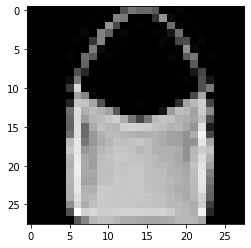

In [350]:
idx = 34
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

Sample instance from the MNIST data set.


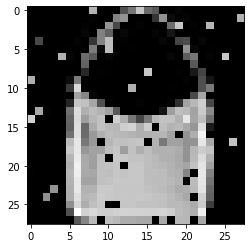

In [351]:
x = X_cd[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

In [352]:
print('test')
evaluate(clf, X_test, y_test)

test
Accuracy: 0.911
Confusion matrix: [[859   1  17  14   0   0  96   0   3   0]
 [  0 978   1   3   1   0   1   0   1   0]
 [ 12   0 903   8 102   0  69   0   2   0]
 [ 15  15   6 901  18   0  24   0   5   0]
 [  2   3  27  33 827   0  61   0   1   0]
 [  1   0   0   0   0 982   0   4   1   4]
 [107   1  46  40  52   0 743   0   4   1]
 [  0   0   0   0   0  14   0 986   2  45]
 [  4   2   0   1   0   0   6   0 981   0]
 [  0   0   0   0   0   4   0  10   0 950]]


In [353]:
print('cd')
evaluate(clf, X_cd, y_cd)

cd
Accuracy: 0.622
Confusion matrix: [[649  10  11 101   2   3  38   0   0   0]
 [  0 836   1   0   0   0   0   0   1   0]
 [  7   0 543   4  56   1  17   0   0   0]
 [  8  19   0 402   2   0   5   0   5   0]
 [  0   0   5   1 101   0   3   0   0   0]
 [  1   1   0   0   0 815   0 105   3   0]
 [319  26 345 394 688   2 880   1  12   1]
 [  0   0   0   0   0  16   0 496   0   3]
 [ 16 103  95  84 151 143  57 367 978 476]
 [  0   5   0  14   0  20   0  31   1 520]]


In [355]:
# Symmetry signal
X_train_perm = np.random.permutation(X_train)
X_test_perm = np.random.permutation(X_test)
X_cd_perm = np.random.permutation(X_cd)
symm_samples_train, orig_preds_train, trans_preds_train = vae.vae.predict(X_train_perm)
symm_samples_test, orig_preds_test, trans_preds_test = vae.vae.predict(X_test_perm)
symm_samples_cd, orig_preds_cd, trans_preds_cd = vae.vae.predict(X_cd_perm)

amp = 1
kl_train = amp * entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = amp * entropy(orig_preds_test.T, trans_preds_test.T)
kl_cd = amp * entropy(orig_preds_cd.T, trans_preds_cd.T)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_cd))
#kl_concat = kl_test
kl_concat.shape

(20000,)

In [356]:
#fit_NNS = False
#if fit_NNS:
#    neigh = NearestNeighbors(1)
#    neigh.fit(X_train_flat)

In [357]:
# Distance signal
#X_train_flat = X_train.reshape(X_train.shape[0], -1)
#X_test_flat = X_test.reshape(X_test.shape[0], -1)
#X_cd_flat = X_cd.reshape(X_cd.shape[0], -1)
    
#d_train = neigh.kneighbors(X_train_flat, return_distance=True)[0].flatten()
#d_test = neigh.kneighbors(X_test_flat, return_distance=True)[0].flatten()
#d_cd = neigh.kneighbors(X_cd_flat, return_distance=True)[0].flatten()

#baseline_std_plus = d_train.mean() + d_train.std()
#baseline_std_minus = d_train.mean() - d_train.std()

#d_concat = np.concatenate((np.random.permutation(d_test), np.random.permutation(d_cd)))
#d_concat.shape

### Analyse signals

In [358]:
#agg = 'mean', 'window' or 'raw'

# distance metric signal
#df = make_data_stream(d_concat, agg='mean')
# kl signal
df = make_data_stream(kl_concat, agg='mean', start=0)

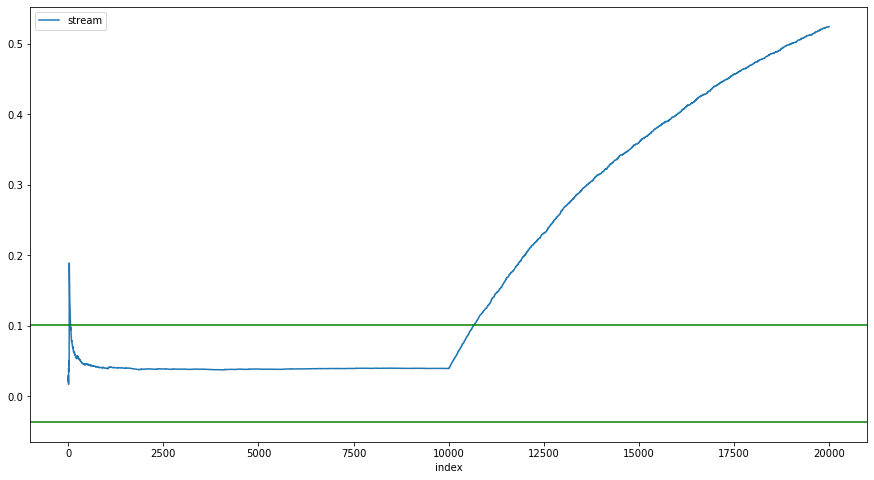

In [359]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus, c='g')
ax.axhline(baseline_std_minus, c='g')

In [360]:
adwin = ADWIN(delta=0.0000002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < 10000:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

/home/Gigio/anaconda3/lib/python3.6/site-packages/skmultiflow/drift_detection/adwin.py:361: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


Change detected in data: 0.0886874926723636 - at index: 10527
Change detected in data: 0.15511421738968348 - at index: 11391
Change detected in data: 0.15845087397007313 - at index: 11423
Change detected in data: 0.16143734075099817 - at index: 11455
Change detected in data: 0.1636419694211477 - at index: 11487
Change detected in data: 0.16774433026844543 - at index: 11519
Change detected in data: 0.16908000130234363 - at index: 11551
Change detected in data: 0.17412129715143349 - at index: 11615
Change detected in data: 0.18190368911567228 - at index: 11743
Change detected in data: 0.18917344289153004 - at index: 11839
Change detected in data: 0.20055242366341158 - at index: 11999
Change detected in data: 0.21506565734803745 - at index: 12223
Change detected in data: 0.225485912402511 - at index: 12415
Change detected in data: 0.2327495595361965 - at index: 12543
Change detected in data: 0.2398766445485764 - at index: 12639
Change detected in data: 0.24941123579963442 - at index: 1276

In [361]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae, X_test, y_test, X_cd, y_cd, cd_start, cd_full, nb_samples_tot, start)

Sample 0 of 6000
Sample 1000 of 6000
Sample 2000 of 6000
Sample 3000 of 6000
Sample 4000 of 6000
Sample 5000 of 6000


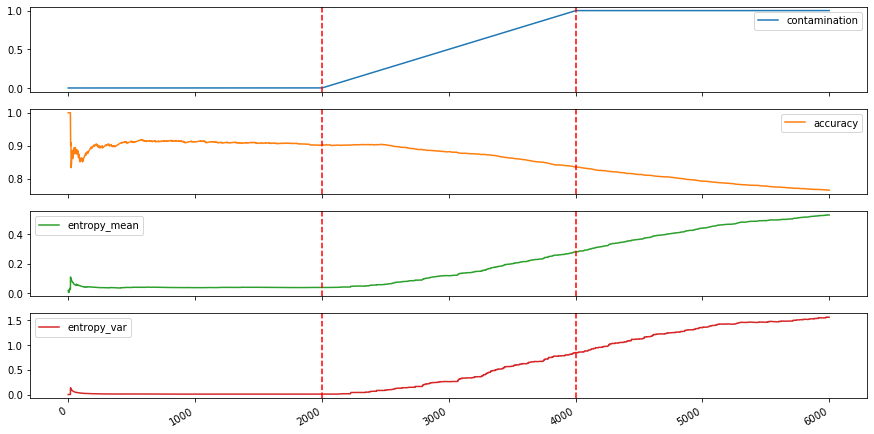

In [362]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

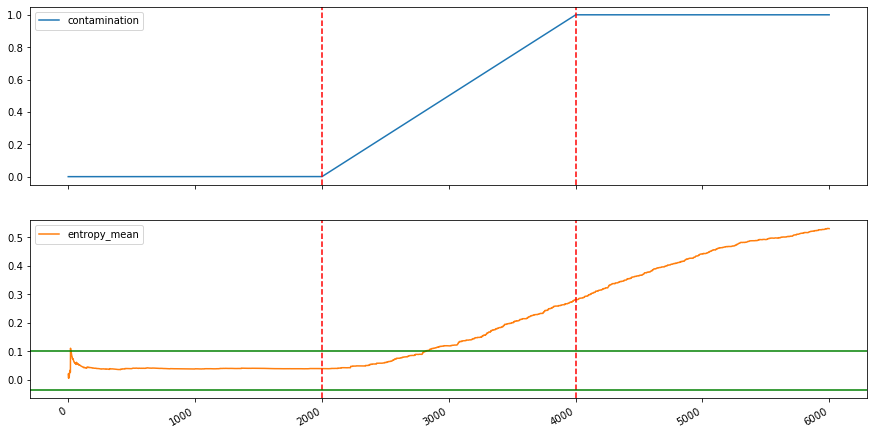

In [363]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

In [337]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.02)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.03777478341560711 - at index: 3967
Change detected in data: 0.038932631759081696 - at index: 4255
Change detected in data: 0.041440885676154546 - at index: 4383
Change detected in data: 0.044385027498502344 - at index: 4607
Change detected in data: 0.04821472317074254 - at index: 4991
Change detected in data: 0.05135698546322425 - at index: 5311
Change detected in data: 0.053293818261383984 - at index: 5631
Change detected in data: 0.05676306273932814 - at index: 5919


In [364]:
df

,rw,entropy,pred_prob,accuracy,contamination,entropy_mean,entropy_var
0,1,0.019904,[0.9962843],1.000000,0.0,0.019904,0.000000
1,1,0.000173,[1.0],1.000000,0.0,0.010039,0.000195
2,1,0.000094,[0.9999988],1.000000,0.0,0.006724,0.000130
3,1,0.012052,[0.9998579],1.000000,0.0,0.008056,0.000094
4,1,0.013084,[0.9870135],1.000000,0.0,0.009062,0.000076
5,1,0.000085,[0.99999976],1.000000,0.0,0.007565,0.000074
6,1,0.003669,[0.9999994],1.000000,0.0,0.007009,0.000064
7,1,0.030835,[0.9991835],1.000000,0.0,0.009987,0.000126
8,1,0.012127,[0.99977237],1.000000,0.0,0.010225,0.000110
9,1,0.133827,[0.63892084],1.000000,0.0,0.022585,0.001626


# Wines

In [388]:
def prepare_data_wines(path_white='/home/fdz/git/concept_drift_exps/data/wine/winequality_white.csv',
                     path_red='/home/fdz/git/concept_drift_exps/data/wine/winequality_red.csv',
                     binary_target=True, scale=True, permute=True, perm_features=5):
    
    df_white = pd.read_csv(path_white)
    df_white['quality'].value_counts() / len(df_white)
    
    if binary_target:
        df_white['target'] = df_white['quality'].apply(lambda x: 0 if x < 6 else 1)
    else:
        df_white['target'] = df_white['quality']
    df_white.drop('quality', axis=1, inplace=True)
    target = 'target'
    # print('White distribution', df_white[target].value_counts() / len(df_white))
    
    features = [col for col in df_white.columns if col != target]
    X, y = df_white[features].values, df_white[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
    y_train = np.delete(y_train, np.where(~y_train.any(axis=0)), axis=1)
    y_test = np.delete(y_test, np.where(~y_test.any(axis=0)), axis=1)
    
    df_red = pd.read_csv(path_red)
    df_red['quality'].value_counts() / len(df_red)
    
    if binary_target:
        df_red['target'] = df_red['quality'].apply(lambda x: 0 if x < 6 else 1)
    else:
        df_red['target'] = df_red['quality']
    df_red.drop('quality', axis=1, inplace=True)
    target = 'target'
    # print('Red distribution ', df_red[target].value_counts() / len(df_red))
    
    features = [col for col in df_red.columns if col != target]
    X_red, y_red = df_red[features].values, df_red[target].values
    if scale:
        X_red = scaler.transform(X_red)
    
    y_red = tf.keras.utils.to_categorical(y_red)
    y_red = np.delete(y_red, np.where(~y_red.any(axis=0)), axis=1)
    
    if not permute:
        return df_white, df_red, X_train, y_train, X_test, y_test, X_red, y_red 
    else:
        perm_1 = np.random.permutation(range(11))[:perm_features]
        perm_2 = np.random.permutation(range(11))[:perm_features]
        
        X_cd = X_test.copy()
        X_cd[:, perm_1] = X_cd[:, perm_2]
        
        y_cd = y_test
        return df_white, df_red, X_train, y_train, X_test, y_test, X_cd, y_cd 

def model_wines(binary_target=True, nb_units=100):
    
    x_in = tf.keras.layers.Input(shape=(11, ))
    x = tf.keras.layers.Dense(nb_units, activation='relu')(x_in)
    #x = tf.keras.layers.Dense(50, activation='relu')(x_in)
    if binary_target:
        out = tf.keras.layers.Dense(2, activation='softmax')(x)
    else:
        out = tf.keras.layers.Dense(7, activation='softmax')(x)
    clf = tf.keras.models.Model(x_in, out)
    clf.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    clf.summary()
    return clf

### Prepare data

In [389]:
# Wines
df_white, df_red, X_train, y_train, X_test, y_test, X_cd, y_cd = prepare_data_wines(path_white='/home/Gigio/git/fork-odcd/data/wine/winequality_white.csv',
                                                                                    path_red='/home/Gigio/git/fork-odcd/data/wine/winequality_red.csv',
                                                                                    permute=True, perm_features=4)

### Train model

In [390]:
# wines
clf = model_wines(nb_units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 11)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 200)               2400      
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 402       
Total params: 2,802
Trainable params: 2,802
Non-trainable params: 0
_________________________________________________________________


In [391]:
#wines 
clf.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Train on 3673 samples, validate on 1225 samples
Epoch 1/100
3673/3673 [==============================] - 3s 809us/step - loss: 0.5944 - acc: 0.6684 - val_loss: 0.5600 - val_acc: 0.7151
Epoch 2/100
3673/3673 [==============================] - 0s 102us/step - loss: 0.5380 - acc: 0.7079 - val_loss: 0.5279 - val_acc: 0.7314
Epoch 3/100
3673/3673 [==============================] - 0s 102us/step - loss: 0.5203 - acc: 0.7316 - val_loss: 0.5157 - val_acc: 0.7388
Epoch 4/100
3673/3673 [==============================] - 0s 102us/step - loss: 0.5119 - acc: 0.7427 - val_loss: 0.5117 - val_acc: 0.7380
Epoch 5/100
3673/3673 [==============================] - 0s 101us/step - loss: 0.5059 - acc: 0.7487 - val_loss: 0.5084 - val_acc: 0.7478
Epoch 6/100
3673/3673 [==============================] - 0s 102us/step - loss: 0.5070 - acc: 0.7517 - val_loss: 0.5040 - val_acc: 0.7445
Epoch 7/100
3673/3673 [==============================] - 0s 102us/step - loss: 0.5033 - acc: 0.7531 - val_loss: 0.5029 - val_acc: 

3673/3673 [==============================] - 0s 102us/step - loss: 0.4538 - acc: 0.7863 - val_loss: 0.4821 - val_acc: 0.7592
Epoch 61/100
3673/3673 [==============================] - 0s 101us/step - loss: 0.4524 - acc: 0.7874 - val_loss: 0.4802 - val_acc: 0.7608
Epoch 62/100
3673/3673 [==============================] - 0s 102us/step - loss: 0.4523 - acc: 0.7833 - val_loss: 0.4775 - val_acc: 0.7682
Epoch 63/100
3673/3673 [==============================] - 0s 103us/step - loss: 0.4527 - acc: 0.7860 - val_loss: 0.4794 - val_acc: 0.7641
Epoch 64/100
3673/3673 [==============================] - 0s 102us/step - loss: 0.4536 - acc: 0.7841 - val_loss: 0.4795 - val_acc: 0.7673
Epoch 65/100
3673/3673 [==============================] - 0s 103us/step - loss: 0.4510 - acc: 0.7871 - val_loss: 0.4869 - val_acc: 0.7543
Epoch 66/100
3673/3673 [==============================] - 0s 102us/step - loss: 0.4518 - acc: 0.7852 - val_loss: 0.4780 - val_acc: 0.7616
Epoch 67/100
3673/3673 [=======================

### Evaluate model

In [396]:
print('Train white')
evaluate(clf, X_train, y_train)

Train white
Accuracy: 0.7949904710046284
Confusion matrix: [[ 772  299]
 [ 454 2148]]


In [397]:
print('Test white')
evaluate(clf, X_test, y_test)

Test white
Accuracy: 0.7714285714285715
Confusion matrix: [[249 115]
 [165 696]]


In [398]:
print((X_cd == X_test).all())

False


In [399]:
print('cd')
evaluate(clf, X_cd, y_cd)

cd
Accuracy: 0.7363265306122448
Confusion matrix: [[201 110]
 [213 701]]


### Train symmetry finder

In [400]:
# wines
vae = vsf.VaeSymmetryFinder(clf, input_shape=(11, ), output_shape=(2, ), intermediate_dim=128, latent_dim=4)

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 11)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 128)          1536        reshape_7[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            516         dense_41[0][0]                   
__________________________________________________________________________________________________
z_log_

In [402]:
vae.fit(X_train, x_test=X_test, epochs=100)

Train on 3673 samples, validate on 1225 samples
Epoch 1/100
3673/3673 [==============================] - 0s 33us/step - loss: 0.0037 - val_loss: 0.0041
Epoch 2/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0039 - val_loss: 0.0035
Epoch 3/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 4/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/100
3673/3673 [==============================] - 0s 30us/step - loss: 0.0034 - val_loss: 0.0032
Epoch 6/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 7/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/100
3673/3673 [==============================] - 0s 32us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 9/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0031 - val_loss: 0.0030
Epoch 10/100
367

3673/3673 [==============================] - 0s 32us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 79/100
3673/3673 [==============================] - 0s 32us/step - loss: 0.0010 - val_loss: 0.0014
Epoch 80/100
3673/3673 [==============================] - 0s 32us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 81/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 82/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0011 - val_loss: 0.0017
Epoch 83/100
3673/3673 [==============================] - 0s 32us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 84/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 85/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0012 - val_loss: 0.0017
Epoch 86/100
3673/3673 [==============================] - 0s 31us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 87/100
3673/3673 [==============================] - 0s 32us/st

### stream

In [459]:
# Symmetry signal
X_train_perm = np.random.permutation(X_train)
X_test_perm = np.random.permutation(X_test)
X_cd_perm = np.random.permutation(X_cd)
symm_samples_train, orig_preds_train, trans_preds_train = vae.vae.predict(X_train_perm)
symm_samples_test, orig_preds_test, trans_preds_test = vae.vae.predict(X_test_perm)
symm_samples_cd, orig_preds_cd, trans_preds_cd = vae.vae.predict(X_cd_perm)

amp = 100
kl_train = amp * entropy(orig_preds_train.T, trans_preds_train.T)
kl_test = amp * entropy(orig_preds_test.T, trans_preds_test.T)
kl_cd = amp * entropy(orig_preds_cd.T, trans_preds_cd.T)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_cd))
#kl_concat = kl_test
kl_concat.shape

(2450,)

In [430]:
# Distance signal
if len(X_train.shape[1:]) > 1:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    X_cd = X_cd.reshape(X_cd.shape[0], -1)
    
neigh = NearestNeighbors(1)
neigh.fit(X_train)
    
d_train = neigh.kneighbors(X_train, return_distance=True)[0].flatten()
d_test = neigh.kneighbors(X_test, return_distance=True)[0].flatten()
d_cd = neigh.kneighbors(X_cd, return_distance=True)[0].flatten()

baseline_std_plus = d_train.mean() + d_train.std()
baseline_std_minus = d_train.mean() - d_train.std()

d_concat = np.concatenate((np.random.permutation(d_test), np.random.permutation(d_cd)))
#kl_concat = kl_test
d_concat.shape

(2450,)

In [460]:
tr = kl_test.shape[0]

In [461]:
#agg = 'mean', 'window' or 'raw'
df = make_data_stream(kl_concat, agg='mean')

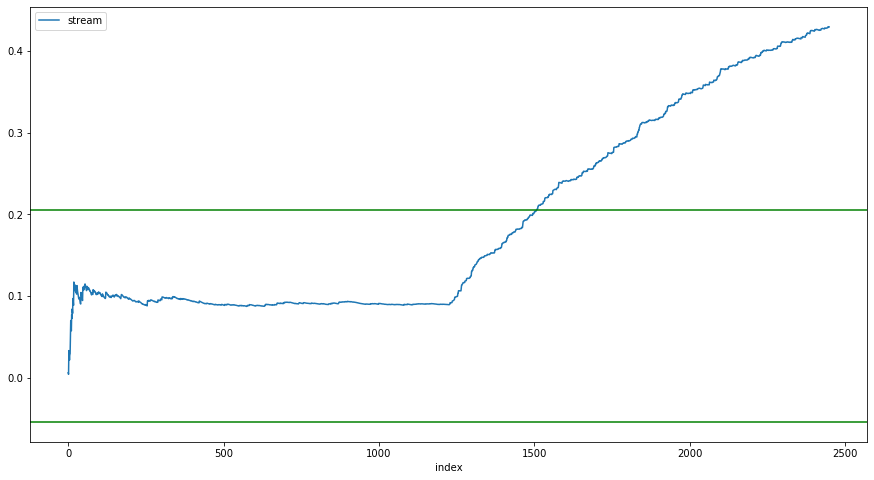

In [462]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus, c='g')
ax.axhline(baseline_std_minus, c='g')

In [463]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.19303944386958297 - at index: 1471
Change detected in data: 0.20332318946753827 - at index: 1503
Change detected in data: 0.22001970368642984 - at index: 1535
Change detected in data: 0.2405641764161348 - at index: 1599
Change detected in data: 0.25236832216577887 - at index: 1663
Change detected in data: 0.28220950444630555 - at index: 1759
Change detected in data: 0.31198224872559666 - at index: 1855
Change detected in data: 0.3227311077220728 - at index: 1919
Change detected in data: 0.3525847642700118 - at index: 2015
Change detected in data: 0.3642267158476461 - at index: 2079
Change detected in data: 0.38225118607457464 - at index: 2143
Change detected in data: 0.3921384301594905 - at index: 2207
Change detected in data: 0.4111696363857426 - at index: 2303
Change detected in data: 0.4172964705270012 - at index: 2367


In [439]:
cd_start = 100
cd_full = int(1.5 * cd_start)
nb_samples_tot = 2000
start = 0
df = sst.rolling_stats(vae, X_test, y_test, X_cd, y_cd, cd_start, cd_full, nb_samples_tot, start)

Sample 0 of 2000
Sample 1000 of 2000


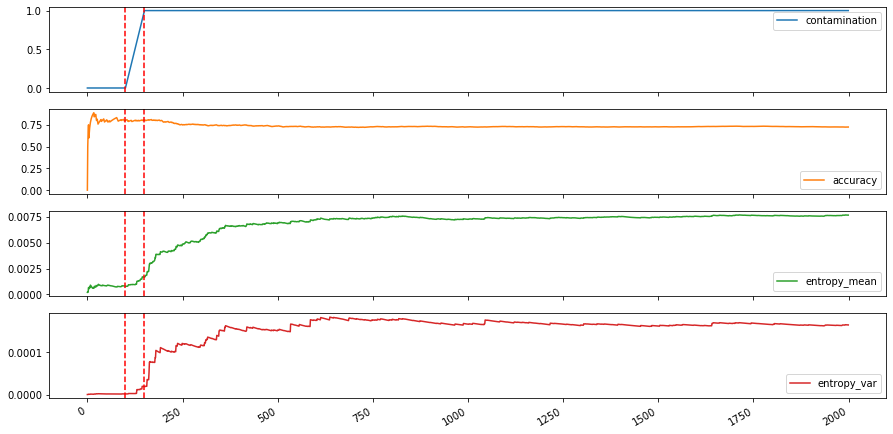

In [440]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

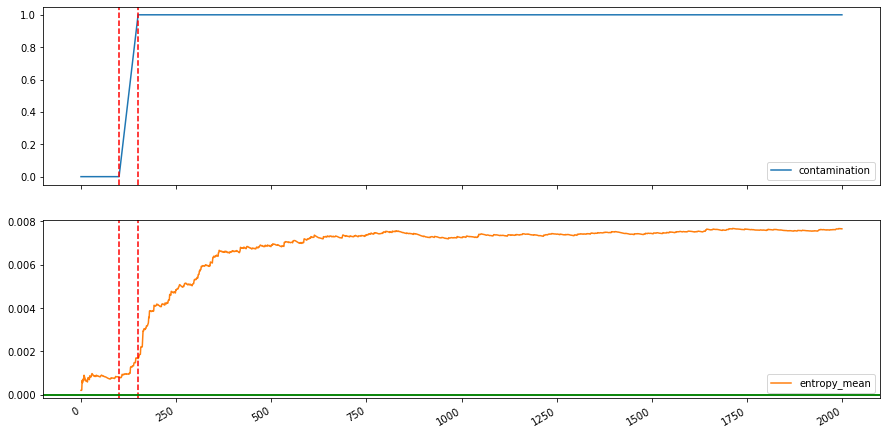

In [441]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus, c='g')
axs[1].axhline(baseline_std_minus, c='g')

In [442]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.02)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

In [443]:
data_stream

0       0.000197
1       0.000217
2       0.000206
3       0.000654
4       0.000539
5       0.000687
6       0.000727
7       0.000641
8       0.000892
9       0.000830
10      0.000772
11      0.000726
12      0.000670
13      0.000622
14      0.000657
15      0.000616
16      0.000602
17      0.000583
18      0.000768
19      0.000782
20      0.000747
21      0.000719
22      0.000689
23      0.000865
24      0.000831
25      0.000833
26      0.000812
27      0.000830
28      0.000939
29      0.000971
          ...   
1970    0.007616
1971    0.007616
1972    0.007613
1973    0.007616
1974    0.007625
1975    0.007621
1976    0.007623
1977    0.007620
1978    0.007628
1979    0.007624
1980    0.007625
1981    0.007621
1982    0.007617
1983    0.007639
1984    0.007656
1985    0.007655
1986    0.007651
1987    0.007650
1988    0.007648
1989    0.007645
1990    0.007653
1991    0.007675
1992    0.007671
1993    0.007668
1994    0.007670
1995    0.007667
1996    0.007665
1997    0.0076